# Bogotá Heatmap

## 0. Import packages and data

In [18]:
# Beginning of code

In [19]:
# Load packages
import os
import pandas as pd 
import numpy as np
import shapely.geometry
import pyproj
import geopandas as gpd
import re
from sklearn.neighbors import DistanceMetric, NearestNeighbors
from itertools import product
import unidecode
from shapely import wkt

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import matplotlib
from sklearn.preprocessing import MinMaxScaler

In [20]:
# Contorno urbano
upla = gpd.read_file("../../Data/upla")
# Quitamos Sumapaz
filtro = ~upla["UPlNombre"].str.contains("RIO")
urbano = upla.loc[filtro,].reset_index(drop = True)

# Bogota completo con zona rural
localidades = gpd.read_file("../../Data/localidades")
# Quitamos Sumapaz
filtro = ~localidades["LocNombre"].str.contains("SUMAPAZ")
bog = localidades.loc[filtro,].reset_index(drop = True)

# Combine both maps to hold the urban zone of Bogotá
bog = gpd.overlay(bog, urbano, how = "intersection", keep_geom_type = True)
bog = bog.dissolve(by = 'LocNombre', aggfunc = 'sum')
# Create an object without boundaries
bog_boundary = gpd.GeoSeries(bog.geometry.unary_union)
bog = bog.reset_index()

mu_hat_final = pd.read_csv('../../Outputs/Data/mu_hat_final.csv', sep = ";")
mu_real = pd.read_csv('../../Outputs/Data/mu_real.csv', sep = ";")
grilla_bog2 = pd.read_csv('../../Data/grilla_bogota2.csv', sep = ";")
underreporting_CUCB = pd.read_csv("../../Outputs/Data/underreporting_cucb.csv", sep = ";")
reporting_CUCB = pd.read_csv("../../Outputs/Data/reporting_cucb.csv", sep = ";")
celdas = pd.read_csv("../../Data/matriz_eventos_subreporte.csv", sep = ";")["celda"]
preport = pd.read_csv("../../Data/matriz_eventos_subreporte.csv", sep = ";").drop(columns = ["celda", "Localidad", "Rep. Rate"]).median(axis = 1)
report = pd.read_csv("../../Data/matriz_eventos_real.csv", sep = ";").drop(columns = ["celda", "Localidad", "Rep. Rate"]).median(axis = 1)

## 1. Create map

In [21]:
cmap_crimen = LinearSegmentedColormap.from_list("", ["white", "#ffb950", "#ffad33", "#ff931f", "#ff7e33", "#fa5e1f", "#ec3f13", "#b81702", "#a50104", "#8e0103", "#7a0103"], N = 50)

In [22]:
mu_real_grilla = grilla_bog2.assign(celda = range(0, len(grilla_bog2))).merge(mu_real, on = "celda", how = "left")
mu_real_grilla["values"] = mu_real_grilla["values"].fillna(0)

In [23]:
scaler = MinMaxScaler()
scaler.fit(mu_real_grilla["values"].values.reshape(-1, 1))
mu_real_grilla["values2"] = scaler.transform(mu_real_grilla["values"].values.reshape(-1, 1))

In [24]:
mu_real_grilla = gpd.GeoDataFrame(mu_real_grilla)
mu_real_grilla['geometry'] = mu_real_grilla['geometry'].apply(wkt.loads)
bog = gpd.GeoDataFrame(bog)
grilla_bog2 = gpd.GeoDataFrame(grilla_bog2)
grilla_bog2['geometry'] = grilla_bog2['geometry'].apply(wkt.loads)

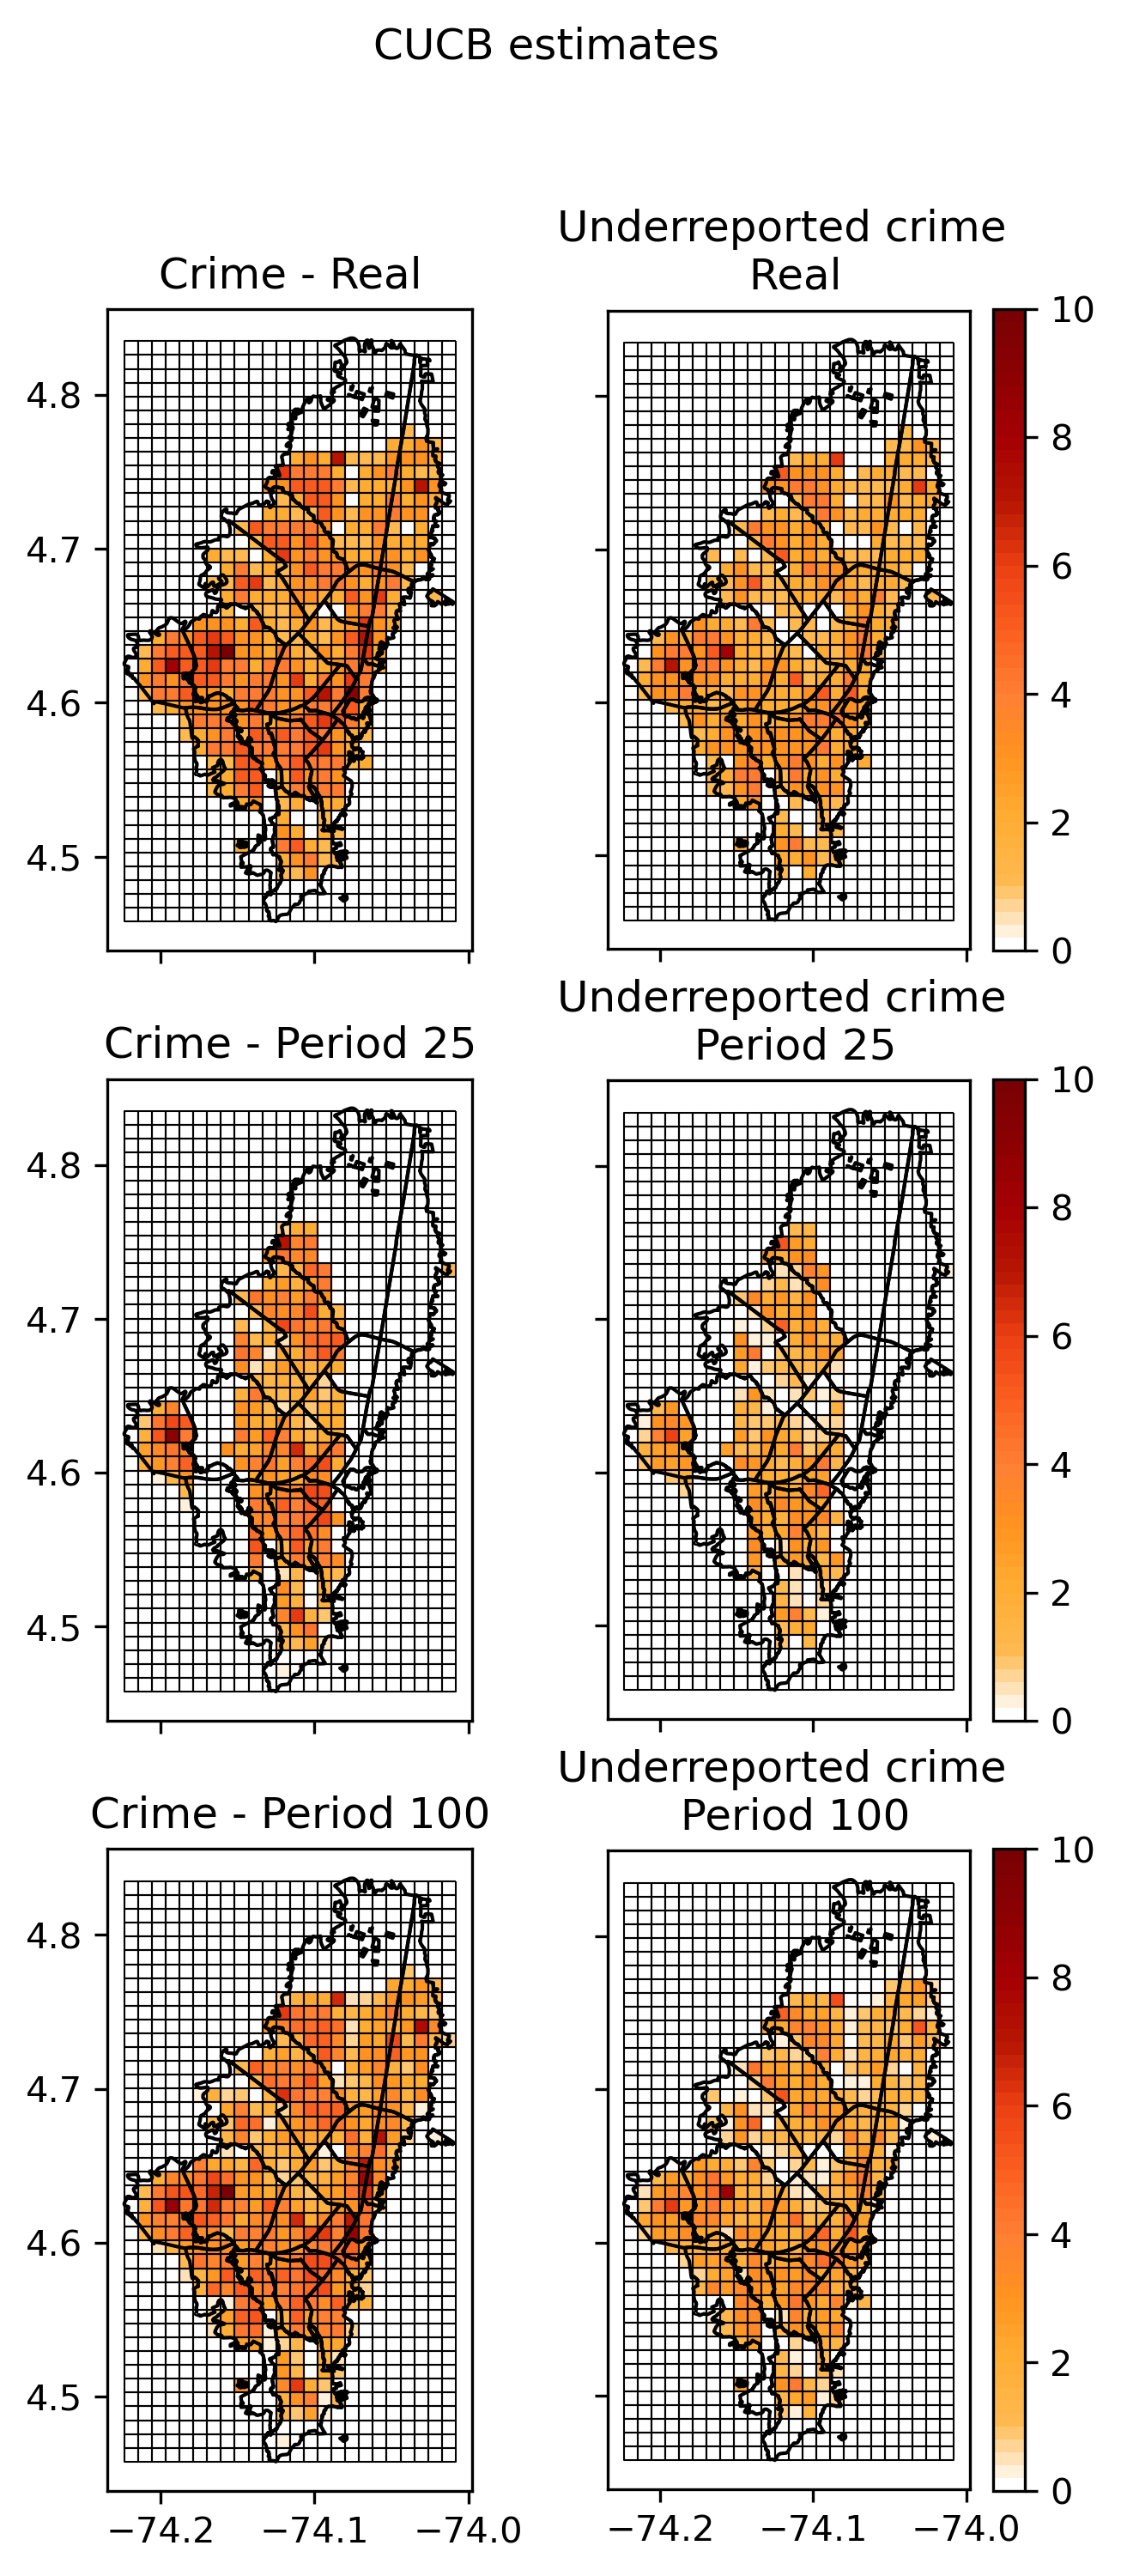

In [26]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (5, 11), dpi = 300, sharex = True, sharey = True)

CUCB = mu_hat_final.loc[(mu_hat_final.model == "CUCB") & (mu_hat_final.t == 25),]
CUCB = grilla_bog2.assign(celda = range(0, len(grilla_bog2))).merge(CUCB, on = "celda")
CUCB.loc[CUCB["value"] == 1, "value"] = 0
# CUCB["value"] = scaler.transform(CUCB["value"].values.reshape(-1, 1))
# CUCB["value"] = np.log(CUCB["value"] + 1)

CUCB3 = pd.concat([celdas, report], axis = 1).rename(columns = {0: "report"}).merge(CUCB, how = "right", on = "celda")
CUCB3 = gpd.GeoDataFrame(CUCB3, geometry = "geometry")

# CUCB3["report"] = scaler.transform(CUCB3["report"].values.reshape(-1, 1))

CUCB3.plot(column = "report", cmap = cmap_crimen, ax = ax[0, 0], legend = False, vmin = 0, vmax = 10)
bog.plot(ax = ax[0, 0], color = 'none', edgecolor = 'black')
grilla_bog2.plot(ax = ax[0, 0], color = "none", edgecolor = "black", linewidth = 0.5, alpha = 1)
ax[0, 0].set_title("Crime - Real")

CUCB25 = reporting_CUCB[["celda", "25"]].merge(CUCB, how = "right", on = "celda")
CUCB25 = gpd.GeoDataFrame(CUCB25, geometry = "geometry")
# CUCB25["25"] = scaler.transform(CUCB25["25"].values.reshape(-1, 1))
CUCB25.plot(column = "25", cmap = cmap_crimen, ax = ax[1, 0], legend = False, vmin = 0, vmax = 10)
bog.plot(ax = ax[1, 0], color = 'none', edgecolor = 'black')
grilla_bog2.plot(ax = ax[1, 0], color = "none", edgecolor = "black", linewidth = 0.5, alpha = 1)
ax[1, 0].set_title("Crime - Period 25")

CUCB100 = reporting_CUCB[["celda", "100"]].merge(CUCB, how = "right", on = "celda")
CUCB100 = gpd.GeoDataFrame(CUCB100, geometry = "geometry")
# CUCB100["100"] = scaler.transform(CUCB100["100"].values.reshape(-1, 1))
CUCB100.plot(column = "100", cmap = cmap_crimen, ax = ax[2, 0], legend = False, vmin = 0, vmax = 10)
bog.plot(ax = ax[2, 0], color = 'none', edgecolor = 'black')
grilla_bog2.plot(ax = ax[2, 0], color = "none", edgecolor = "black", linewidth = 0.5, alpha = 1)
ax[2, 0].set_title("Crime - Period 100")

CUCB2 = pd.concat([celdas, preport], axis = 1).rename(columns = {0: "preport"}).merge(CUCB, how = "right", on = "celda")
CUCB2 = gpd.GeoDataFrame(CUCB2, geometry = "geometry")
# CUCB2["preport"] = scaler.transform(CUCB2["preport"].values.reshape(-1, 1))
CUCB2.plot(column = "preport", cmap = cmap_crimen, ax = ax[0, 1], legend = True, vmin = 0, vmax = 10)
bog.plot(ax = ax[0, 1], color = 'none', edgecolor = 'black')
grilla_bog2.plot(ax = ax[0, 1], color = "none", edgecolor = "black", linewidth = 0.5, alpha = 1)
ax[0, 1].set_title("Underreported crime \n Real")

CUCB24 = underreporting_CUCB[["celda", "24"]].merge(CUCB, how = "right", on = "celda")
CUCB24 = gpd.GeoDataFrame(CUCB24, geometry = "geometry")
# CUCB24["24"] = scaler.transform(CUCB24["24"].values.reshape(-1, 1))
CUCB24.plot(column = "24", cmap = cmap_crimen, ax = ax[1, 1], legend = True, vmin = 0, vmax = 10)
bog.plot(ax = ax[1, 1], color = 'none', edgecolor = 'black')
grilla_bog2.plot(ax = ax[1, 1], color = "none", edgecolor = "black", linewidth = 0.5, alpha = 1)
ax[1, 1].set_title("Underreported crime \n Period 25")

CUCB100 = underreporting_CUCB[["celda", "100"]].merge(CUCB, how = "right", on = "celda")
CUCB100 = gpd.GeoDataFrame(CUCB100, geometry = "geometry")
# CUCB100["100"] = scaler.transform(CUCB100["100"].values.reshape(-1, 1))
CUCB100.plot(column = "100", cmap = cmap_crimen, ax = ax[2, 1], legend = True, vmin = 0, vmax = 10)
bog.plot(ax = ax[2, 1], color = 'none', edgecolor = 'black')
grilla_bog2.plot(ax = ax[2, 1], color = "none", edgecolor = "black", linewidth = 0.5, alpha = 1)
ax[2, 1].set_title("Underreported crime \n Period 100")

plt.suptitle("CUCB estimates")
plt.savefig(r"../../Outputs/Figures/figure_15_CUCB_crime_estimates.png")